# Assignment Week 10: Text Mining using Dimensionality Reduction Methods

## Student ID: 250850926

This dataset comes from the website [Internet Movie Database](https://www.imdb.com/), and represents 1,000 reviews which were labeled (by humans) as positive or negative, see [here](http://ai.stanford.edu/~amaas/data/sentiment/) for more details. In this coursework, we will study how we can use dimensionality reduction methods to improve our understanding of text data and to predict the sentiment of a set of texts. This application of data science is called [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) and it is widely used across many fields to get automated feedback when text opinions are expressed. While most modern methods of sentiment analysis are using complex deep learning methods, the tools we have seen this week can be readily applied to get a good idea of what our users are expressing.

In [1]:
# Import other packages if you need them!
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error


# Plotting
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Data import

The dataset comes with the text and a binary variable which represents the sentiment, either positive or negative. The following code imports the data, splits it into train and test, and applies the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) (see the lectures, slide 34).

In [2]:
# Be sure to first leave the data here!
imdb_data = pd.read_excel('IMDB_Sample.xlsx')


# Scikit-Learn works by first defining the der 
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf=True # Use sublinear weights (softplus)
                      )

# Train / test split
x_train, x_test, y_train, y_test = train_test_split(imdb_data['texts'],
                                                    imdb_data['class'],
                                                    test_size=0.3,
                                                    random_state=20210318)

# Calculate the Tf-Idf transform.
TfIDF_train = TfIDFTransformer.fit_transform(x_train)
TfIDF_test = TfIDFTransformer.transform(x_test)

# Turn to dense matrix as PCA does not like sparse ones.
TfIDF_train = TfIDF_train.toarray()
TfIDF_test = TfIDF_test.toarray()

From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required).  The output is a **sparse matrix** with the 236 words that do not appear in more than 95% of texts nor in less than 5% of texts. These matrices only store the relevant information! They are *much* more efficient in-memory.  Sadly, PCA nor torch deal very well with sparse matrices without further processing, so we turn them into dense matrices.

We can check the outputs of the first row with the below code.

In [3]:
print(TfIDF_train)

[[0.         0.18432253 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.14711571 0.         0.11950076 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.08508829 ... 0.         0.16131157 0.        ]]


Each column represents one word and each non-zero value represents the Tf-IDF weight as seen in the lectures. To find out which word is which in the index, you can use the [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [4]:
print('There are %i words in the index.' % len(TfIDFTransformer.get_feature_names()))

There are 236 words in the index.


## Task 1: PCA decomposition of the texts. [35 pts]

Now you have the TfIDF matrix, We can start working on the data. As a first step, we want to explore what some commonly occuring concepts in the text reviews. We can do this using PCA. A PCA transform of the TF-IDF matrix will give you a basis of the text data, each representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic.

1. First, calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts. 

**Written answer: Exactly how many concepts do you need to correctly explain at least 75% of the data? (note we need the exact # of concepts)**  [15 pts]

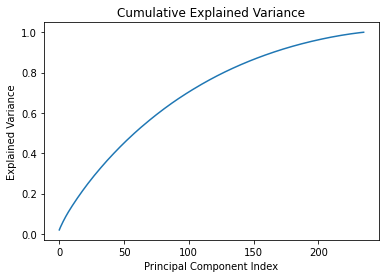

In [5]:
# Your code here.
pca_max = PCA()
pca_max.fit_transform(TfIDF_train)
variance = pca_max.explained_variance_ratio_

# Make the plot
plt.plot(range(0,len(np.cumsum(variance))), np.cumsum(variance))
plt.title('Cumulative Explained Variance')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Component Index')
plt.show()

In [6]:
# To get the exact index where the variance is above 75%
for i in range(len(variance)):
    if (np.cumsum(variance)[i] >= 0.75):
        print(i)
        break;

113


**Written answer: ** You need 113 concepts to correctly explain 75% of the data.

2. Study the first three concepts. To do this, show the 10 words that are the most important in the each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).

**Written answer: What is the cumulative variance explained by these three concepts? What would you name each of these concepts?** [10 pts]
*Hint: if in a concept you would get the words 'dog', 'cat', 'fish' as the most important ones, you could name the concept 'animals' or 'pets'.*

In [7]:
# Explained variance.
print('Cumulative variance explained by first 3 concepts: ')
for i in range(0, 3):
    print(np.cumsum(variance)[i])

components = np.abs(pca_max.components_)


Cumulative variance explained by first 3 concepts: 
0.019683226443076664
0.0349270558928448
0.048604638960120294


In [8]:
# Get words per component
most_important = [(-components[i]).argsort()[:10] for i in range(3)]
most_important = np.asarray(most_important)

In [9]:
# Concept 1, 2 and 3
for i in range(len(most_important)):
    print('\nMost important concepts ', i+1, ':')
    for j in range(len(most_important[i])):
        print(TfIDFTransformer.get_feature_names()[most_important[i][j]])


Most important concepts  1 :
movie
film
bad
movies
films
like
watch
best
woman
don

Most important concepts  2 :
film
bad
films
series
way
great
like
story
love
say

Most important concepts  3 :
film
movie
series
man
old
funny
seen
star
acting
new


**Written answer: ** 

Cumulative variance explained by first 3 concepts: 

0.019683226443076664

0.0349270558928448

0.048604638960120294

Concept 1 name: Movies

Concept 2 name: Romantic Movies/Shows 

Concept 3 name: Comedies

3. Apply the PCA transformation to the test dataset. Using only the first two components, make a scatter plot of the cases. Identify positive and negative cases by colouring points with different sentiments with different colours. 

**Written answer: What can you say about where the positive and negative cases lie in your plot? Could we use these concepts to discriminate positive and negative cases? If yes, why? If no, why not? Discuss your findings.** [10 pts]

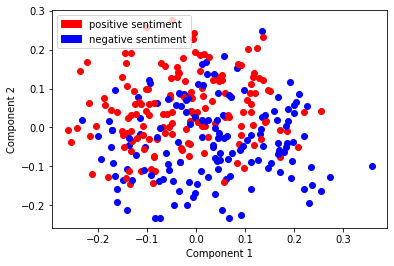

In [10]:
# Apply the test data
p = pca_max.transform(TfIDF_test)

fir, ax = plt.subplots()
# Plot the two different set of points filtering by label.
for i in range(len(y_test)):
    if (y_test.iloc[i] == 0):
        ax.scatter(p[:,0][i], p[:,1][i], color='blue')
    else:
        ax.scatter(p[:,0][i], p[:,1][i], color='red')

red_patch = mpatches.Patch(color='red', label='positive sentiment')
blue_patch = mpatches.Patch(color='blue', label='negative sentiment')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

**Written answer:** It would be hard to distinguish between positive and negative cases with these concepts because there is no solid clustering, as we can see in the plot. It seems as though a cluster is trying to form (negative cases on the bottom, and positive cases on the top), however the data in between is still mixed together. 

## Task 2: Autoencoders [35 pts]

We will see now the ability of autoencoders to compress the data. Train an autoencoder that compresses the data to 60 neurons in the encoding layer as shown in lab 10.2, to be trained over the original TfIDF train dataset. Use a total of 5 fully connected layers going from 236 to 100 to 60 to 100 to 236 units. Use a relu non-linearity for each of them. Then try at two more variations of this network. You could vary the number of hidden units, number of layers, or the type of nonlinearity that you are using. Train the models, each time reducing model reconstruction error. For each model you train, plot the reconstruction error (MSE) over the train set and the test set as you train every 100 rounds. 

**Written answer: Which of your models performs the best? After how many epochs does your best model reach convergence? Does your model overfit? If yes, why do you think this is? If no, why?** [10 pts each architecture plus 5 pts arguing which one is better plus the explaining of overfitting]

In [11]:
# Model architecture and definition
scaler = StandardScaler()
X_scaled = scaler.fit_transform(TfIDF_train)
X_scaled = X_scaled.astype(np.float32)

scaler = StandardScaler()
X_test = scaler.fit_transform(TfIDF_test)
X_test = X_test.astype(np.float32)

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(236,100),
            torch.nn.ReLU(),
            nn.Linear(100,60),
            torch.nn.ReLU(),
            nn.Hardtanh(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(60,100),
            torch.nn.ReLU(),
            nn.Linear(100,236),
            torch.nn.ReLU(),
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#build model
auto_enc = autoencoder()

#define loss function
loss_fn = torch.nn.MSELoss()

#define learning rate
learning_rate = 1e-1

#convert dataset to tensors
X_scaled = torch.from_numpy(X_scaled)
X_test = torch.from_numpy(X_test)

In [12]:
# Train!
#train model
mse = []
mse_test = []
for t in range (50000):
  y_pred = auto_enc(X_scaled)
  loss = loss_fn(y_pred, X_scaled)
  if t % 100 == 99:
        #print(t, loss.item())
        mse.append(loss.item())
        test_py = auto_enc(X_test)
        loss_test = loss_fn(test_py, X_test)
        mse_test.append(loss_test.item())
  auto_enc.zero_grad()
  loss.backward()
  with torch.no_grad():
        for param in auto_enc.parameters():
            param -= learning_rate * param.grad 



Min Train MSE:  0.42354121804237366
Min Test MSE:  0.8407686948776245


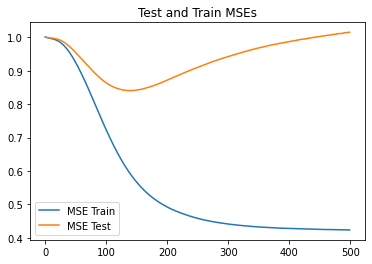

In [13]:
print('Min Train MSE: ', min(mse))
print('Min Test MSE: ', min(mse_test))
plt.plot(mse, label='MSE Train')
plt.plot(mse_test, label='MSE Test')
plt.legend()
plt.title('Test and Train MSEs')
plt.show()

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(TfIDF_train)
X_scaled = X_scaled.astype(np.float32)

scaler = StandardScaler()
X_test = scaler.fit_transform(TfIDF_test)
X_test = X_test.astype(np.float32)

class autoencoder2(nn.Module):
    def __init__(self):
        super(autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(236,150),
            torch.nn.ReLU(),
            nn.Linear(150,100),
            torch.nn.ReLU(),
            nn.Hardtanh(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(100,150),
            torch.nn.ReLU(),
            nn.Linear(150,236),
            torch.nn.ReLU(),
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#build model
auto_enc2 = autoencoder2()

#define loss function
loss_fn = torch.nn.MSELoss()

#define learning rate
learning_rate = 1e-1

#convert dataset to tensors
X_scaled = torch.from_numpy(X_scaled)
X_test = torch.from_numpy(X_test)

#train model
mse2 = []
mse_test2 = []
for t in range (50000):
  y_pred = auto_enc2(X_scaled)
  loss = loss_fn(y_pred, X_scaled)
  if t % 100 == 99:
        #print(t, loss.item())
        mse2.append(loss.item())
        test_py = auto_enc2(X_test)
        loss_test = loss_fn(test_py, X_test)
        mse_test2.append(loss_test.item())
  auto_enc2.zero_grad()
  loss.backward()
  with torch.no_grad():
        for param in auto_enc2.parameters():
            param -= learning_rate * param.grad 

Min Train MSE:  0.3309250771999359
Min Test MSE:  0.7543907761573792


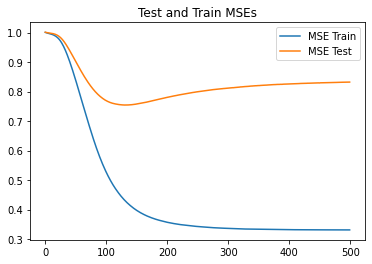

In [15]:
# Plot errors
print('Min Train MSE: ', min(mse2))
print('Min Test MSE: ', min(mse_test2))
plt.plot(mse2, label='MSE Train')
plt.plot(mse_test2, label='MSE Test')
plt.legend()
plt.title('Test and Train MSEs')
plt.show()

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(TfIDF_train)
X_scaled = X_scaled.astype(np.float32)

scaler = StandardScaler()
X_test = scaler.fit_transform(TfIDF_test)
X_test = X_test.astype(np.float32)

class autoencoder3(nn.Module):
    def __init__(self):
        super(autoencoder3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(236,150),
            torch.nn.ReLU(),
            nn.Linear(150,100),
            torch.nn.ReLU(),
            nn.Linear(100,60),
            torch.nn.ReLU(),
            nn.Hardtanh(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(60,100),
            torch.nn.ReLU(),
            nn.Linear(100,150),
            torch.nn.ReLU(),
            nn.Linear(150,236),
            torch.nn.ReLU(),
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#build model
auto_enc3 = autoencoder2()

#define loss function
loss_fn = torch.nn.MSELoss()

#define learning rate
learning_rate = 1e-1

#convert dataset to tensors
X_scaled = torch.from_numpy(X_scaled)
X_test = torch.from_numpy(X_test)

#train model
mse3 = []
mse_test3 = []
for t in range (50000):
  y_pred = auto_enc3(X_scaled)
  loss = loss_fn(y_pred, X_scaled)
  if t % 100 == 99:
        #print(t, loss.item())
        mse3.append(loss.item())
        test_py = auto_enc3(X_test)
        loss_test = loss_fn(test_py, X_test)
        mse_test3.append(loss_test.item())
  auto_enc3.zero_grad()
  loss.backward()
  with torch.no_grad():
        for param in auto_enc3.parameters():
            param -= learning_rate * param.grad 

Min Train MSE:  0.36424964666366577
Min Test MSE:  0.7559438943862915


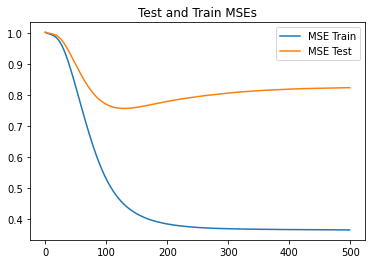

In [17]:
print('Min Train MSE: ', min(mse3))
print('Min Test MSE: ', min(mse_test3))
plt.plot(mse3, label='MSE Train')
plt.plot(mse_test3, label='MSE Test')
plt.legend()
plt.title('Test and Train MSEs')
plt.show()

**Written answer:** The second model and third model interchangeably have the best performance (changes when you re-train the model). Both these models converge at about 20,000 epochs. All of the models overfit because the test MSE reaches a low and then begins to increase, while the train data converges and continues to steadily decrease/remain at a low value. This indicates overfitting because, as the model trains with the training data more and more, it is fitting too well to the train data without taking into consideration that unknown data is not included, thus the test data MSE begins increasing at a certain point. 

## Task 3: Benchmarking predictive capabilities of the compressed data. [30 pts]

For the final task, you will benchmark the different compression algorithms over the original data. For this:

1. Train a regularized logistic regression over the original TfIDF train set (with no compression) to predict the positive / negative class label for each movie. Calculate the AUROC over the test set.
2. Train a regularized logistic regression over the PCA-reduced dataset (with 60 components), and calculate the AUROC over the PCA-transformed test set.
3. Train a regularized logistic regression over the encoded dataset (with 60 variables), and calculate AUROC over the encoded test set.

**Written answer 1: Compare the performance of the three models: how do they compare?**

**Written answer 2: Which of the two compression methods (methods 2 and 3) is better at compressing the data without altering its predictive capacity? Why do you think this happens?**

auroc score:  0.7545810354029532


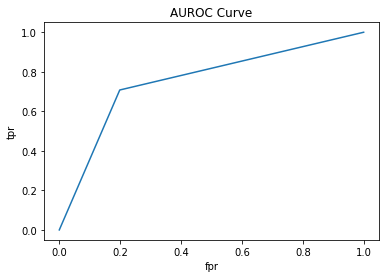

In [18]:
# Full dataset regression and AUC plot / calculation
reg = LogisticRegressionCV(penalty='l2', max_iter=1000)
reg.fit(TfIDF_train, y_train)
py = reg.predict(TfIDF_test)
roc_score = roc_auc_score(y_test, py)
fpr, tpr, thresholds = roc_curve(y_test, py)

print('auroc score: ', roc_score)
plt.plot(fpr, tpr)
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.title('AUROC Curve')
plt.show()

auroc score:  0.7176214196762142


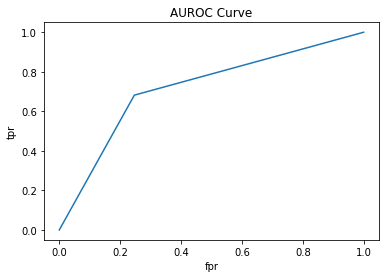

In [19]:
# PCA dataset regression and AUC plot / calculation
pca = PCA(n_components=60)
pca.fit(TfIDF_train)
pca_train = pca.transform(TfIDF_train)
pca_test = pca.transform(TfIDF_test)


reg = LogisticRegressionCV(penalty='l2', max_iter=1000)
reg.fit(pca_train, y_train)
py = reg.predict(pca_test)
roc_score = roc_auc_score(y_test, py)
fpr, tpr, thresholds = roc_curve(y_test, py)

print('auroc score: ', roc_score)
plt.plot(fpr, tpr)
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.title('AUROC Curve')
plt.show()

auroc score:  0.647304750044476


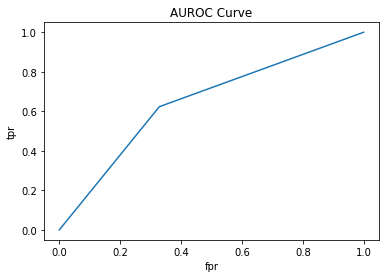

In [20]:
# Autoencoder dataset regression and AUC plot / calculation
X_train_reconstructed = auto_enc(X_scaled).detach().numpy()
X_test_reconstructed = auto_enc(X_test).detach().numpy()

reg = LogisticRegressionCV(penalty='l2', max_iter=2000)
reg.fit(X_train_reconstructed, y_train)
py = reg.predict(X_test_reconstructed)
roc_score = roc_auc_score(y_test, py)
fpr, tpr, thresholds = roc_curve(y_test, py)

print('auroc score: ', roc_score)
plt.plot(fpr, tpr)
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.title('AUROC Curve')
plt.show()

**Written answer:** The uncompressed dataset performs the best as expected, the PCA compressed dataset performs second, and the autoencoder dataset performs the worst. PCA is the better choice for compressing this data. I think this happens because the data is more simple and the autoencoder ends up overfitting, whereas PCA does not. Perhaps with a better model, the autoencoder reduced data would perform better than PCA. 